# About this kernel

The goal is to:
* Investigate the problem of null masks by exploring the distribution of NaN per image.
* Reduce image size to 224x224 for simpler models.
* Create a lightweight CNN to predict if a certain image has no defect (i.e., it has 4 missing masks). This will be useful in order to reduce the computation power needed to train a segmentation model (e.g. Mask R-CNN), since we can immediately discard the image with 4 missing masks.

This is a work in progress, and I will update the kernel in the next few days. I'll work hard on this if you show some support :)

### Updates
* V9: Changed model from MobileNet to DenseNet.

In [1]:
import os
import json
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../input/train.csv')

print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
# 查看图片大小
path = os.path.join("../input/train_images", "00031f466.jpg")
img = Image.open(path)

img.format, img.size

('JPEG', (1600, 256))

In [4]:
submission_df = pd.read_csv('../input/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [5]:
unique_test_images = submission_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
).unique()

unique_test_images

array(['004f40c73.jpg', '006f39c41.jpg', '00b7fb703.jpg', ...,
       'ffbf79783.jpg', 'ffc9a6187.jpg', 'ffdb60677.jpg'], dtype=object)

# EDA

This EDA will mainly focus on detecting how the null masks are distributed. We will group all the `ImageId_ClassId` by their respective ImageId, and keep track of the number of missing masks for each image.

In [6]:
train_df['isNan'] = pd.isna(train_df['EncodedPixels'])
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
)
train_df.head()

,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,False,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,True,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,True,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,True,0002cc93b.jpg
4,00031f466.jpg_1,NaN,True,00031f466.jpg


In [7]:
train_nan_df = train_df.groupby(by='ImageId', axis=0).agg('sum')
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={'isNan': 'missingCount'}, inplace=True)
train_nan_df['missingCount'] = train_nan_df['missingCount'].astype(np.int32)
train_nan_df['allMissing'] = (train_nan_df['missingCount'] == 4).astype(int)

train_nan_df.head()

,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [8]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

(1801, 1)


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [9]:
train_nan_df['missingCount'].hist()
train_nan_df['missingCount'].value_counts()

3    6239
4    5902
2     425
1       2
Name: missingCount, dtype: int64

We notice that an overwhelming number of images have 3 to 4 missing masks. In fact, all except 2 images have 2+ missing masks. This means that we would basically need to train the final segmentation model on less than half of the data points.

# Reducing Image Size

In [10]:
# def load_img(code, base, resize=True):
#     path = f'{base}/{code}'
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     if resize:
#         img = cv2.resize(img, (256, 256))
#     return img

# def validate_path(path):
#     if not os.path.exists(path):
#         os.makedirs(path)

In [11]:
# train_path = '../tmp/train'
# validate_path(train_path)

# for code in tqdm(train_nan_df['ImageId']):
#     img = load_img(
#         code,
#         base='../input/train_images',
#         resize=False
#     )
#     path = code.replace('.jpg', '')
#     cv2.imwrite(f'{train_path}/{path}.png', img)

In [12]:
# train_nan_df['ImageId'] = train_nan_df['ImageId'].apply(
#     lambda x: x.replace('.jpg', '.png')
# )

In [3]:
import keras
keras.__version__

'2.2.4'

# Modelling

In [13]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_nan_df,
        directory='../input/test_images/',
        x_col='ImageId',
        class_mode=None,
        target_size=(1600, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_nan_df, 
        directory='../input/train_images/',
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='other',
        target_size=(1600, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 10683 images.
Found 1885 images.
Found 1801 images.


In [14]:
from keras.applications.densenet import DenseNet121

def build_model():
#     densenet = DenseNet121(
#         include_top=False,
#         input_shape=(256,256,3),
#         weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5'
#     )
    densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(1600, 256, 3))
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Nadam(),
        metrics=['accuracy']
    )
    
    return model

In [15]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 50, 8, 1024)       7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2

In [ ]:
total_steps = train_nan_df.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    'remove_model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint, reduce_lr]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


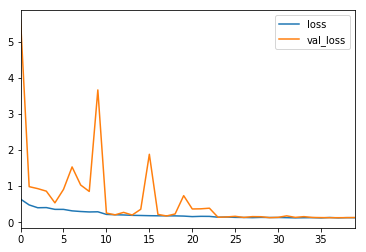

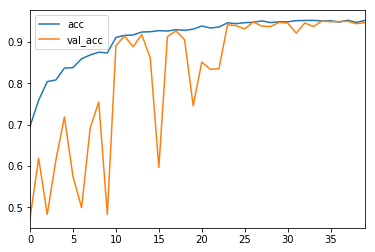

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## Save results as CSV files

In [ ]:
model.load_weights('../save_model/remove_model.h5')

In [17]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)
test_nan_df['allMissing'] = y_test

57/57 [==============================] - 21s 373ms/step


In [18]:
history_df.to_csv('history.csv', index=False)
train_nan_df.to_csv('train_missing_count.csv', index=False)
test_nan_df.to_csv('test_missing_count.csv', index=False)